# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [2]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
#!pip install census
#!pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)




# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# Create query to pull data
naep_query_math_2015 = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'
)
naep_query_math_2015 

# Use requests to call API
naep_query_math_2015_resp = requests.get(naep_query_math_2015)
naep_query_math_2015_resp

# Get json contents of the response
naep_query_math_2015_json = naep_query_math_2015_resp.json()
naep_query_math_2015_json

# Turn result into a dataframe
naep_math_2015_df = pd.DataFrame(naep_query_math_2015_json['result'])
naep_math_2015_df

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

<Response [200]>

{'status': 200,
 'result': [{'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 275.020976636682,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 275.638637274477,
   'isStatDisplayable': 1,
   'errorFlag': 0}]}

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0


### What do scores look like between the genders?

The scores look virtualy the same between the genders, with males have a slightly lower mean score (275.02) compared to females (275.64). The difference is so slight (difference female-male = 0.62, most likely statistically insignificant). 

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
# Create query to pull data for multiple years
naep_query_math = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'
)
naep_query_math

# Use requests to call API
naep_query_math_resp = requests.get(naep_query_math)
naep_query_math_resp

# Get json contents of the response
naep_query_math_json = naep_query_math_resp.json()
naep_query_math_json

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

<Response [200]>

{'status': 200,
 'result': [{'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 277.167170641967,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 274.597823860242,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   's

In [4]:
# Turn result into a dataframe
naep_math_df = pd.DataFrame(naep_query_math_json['result'])
naep_math_df

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,jurisLabel,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,California,GENDER,Gender,2,Female,276.721824,1,0


## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

In [5]:
male_math = naep_math_df[naep_math_df['varValueLabel']=='Male']
female_math = naep_math_df[naep_math_df['varValueLabel']=='Female']

Text(0.5, 1.0, 'Mean Math Scores of Male and Female Students from 2013-2019')

(272.0, 278.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Mean Math Score')

([<matplotlib.axis.XTick at 0x135ea5610>,
 [Text(2013, 0, '2013'),
  Text(2015, 0, '2015'),
  Text(2017, 0, '2017'),
  Text(2019, 0, '2019')])

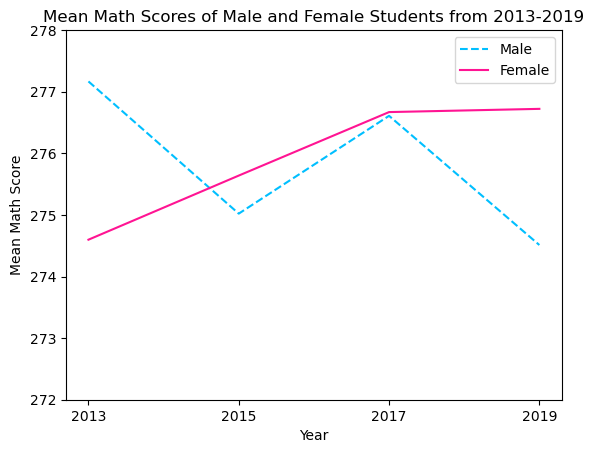

In [6]:
plt.plot(male_math.year, male_math.value, color="deepskyblue", label="Male", linestyle="--")
plt.plot(female_math.year, female_math.value, color="deeppink", label="Female", linestyle="-")
plt.title("Mean Math Scores of Male and Female Students from 2013-2019")
plt.ylim(272,278)
plt.xlabel("Year")
plt.ylabel("Mean Math Score")
plt.legend()
years = range(2013, 2020)
odd_years = [year for year in years if year % 2 != 0] 
plt.xticks(odd_years)

plt.show()

In [7]:
# (ggplot(naep_math_df, aes(x = 'year',
#                          y = 'value',
#                          color = 'varValueLabel',
#                          linetype = 'varValueLabel')) +
#  geom_line() + 
#  xlab("Year") +
#  ylab("Score") +
#  labs(color = "Sex",
#      linetype = "Sex") +
#  scale_y_continuous(limits = (272, 277)) +
#  scale_x_continuous(breaks=[2013, 2015, 2017, 2019]) +
#  ggtitle("Mean Math Scores of Male and Female Students from 2013-2019") +
#  scale_color_manual(values={'Male': 'deepskyblue', 'Female': 'deeppink'}) +
#  scale_linetype_manual(values={'Male': 'solid', 'Female': 'dashed'}) +
#  theme_minimal()
# )

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [8]:
# Define function
def construct_naep_query(year, place):
    if isinstance(year, list):
        year_str = ','.join(year)
        
    else:
        year_str = year

    naep_query = (
        'https://www.nationsreportcard.gov/' +
        'Dataservice/GetAdhocData.aspx?' +
        'type=data&subject=mathematics&grade=8&' +
        'subscale=MRPCM&variable=GENDER&jurisdiction=' + place + '&stattype=MN:MN&' +
        'Year=' + year_str
    )

    return naep_query

In [9]:
# Execute function
print("Single year Query:")
print(construct_naep_query('2015', 'CA'))
print("List of years Query: ")
print(construct_naep_query(['2013', '2015', '2017', '2019'], 'CA'))

Single year Query:
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015
List of years Query: 
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019


In [10]:
assert construct_naep_query('2015', 'CA') == (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&'
    'Year=2015'), "The queries do not match"
print("The queries match")

assert construct_naep_query(['2013', '2015', '2017', '2019'], 'CA') == (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&'
    'Year=2013,2015,2017,2019'), "The queries do not match"
print("The queries match")

The queries match
The queries match


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [11]:
# Define function 
def process_naep_query()

SyntaxError: expected ':' (167592606.py, line 2)

In [12]:
def naep_api_calls(years: list,
                   baseurl = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1 = 'type=data&subject=writing&grade=8&',
                   query_part3 = '&subscale=WRIRP&variable=GENDER&jurisdiction=CA&stattype=MN:MN'):
    
    dflist = []
    
    for year in years:
        naep_query = baseurl + query_part1  + query_part3 + ('&year=' + str(year))
        naep_resp = requests.get(naep_query)

        try:
            naep_resp_df = pd.DataFrame(naep_resp.json()['result'])
            dflist.append(naep_resp_df)
        except Exception as e:
            print("Failed to get result from API for grade {} due to error:".format(str(year)))
            print(e)
        
    combined_result_df = pd.concat(dflist)
    
    return(combined_result_df)


naep_api_calls(years = [2013, 2015])

Failed to get result from API for grade 2013 due to error:
Invalid control character at: line 1 column 110 (char 109)
Failed to get result from API for grade 2015 due to error:
Invalid control character at: line 1 column 110 (char 109)


ValueError: No objects to concatenate

In [13]:
def naep_api_calls(years, baseurl = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1 = 'type=data&subject=writing&grade=8&',
                   query_part3 = '&subscale=WRIRP&variable=GENDER&jurisdiction=CA&stattype=MN:MN'):
    dflist = []

    for year in years:
        query = baseurl + query_part1 + query_part3 + ('&Year=' + str(year))
        try:
            df = pd.read_json(query)
            dflist.append(df)
        except Exception as e:
            print("Failed to get result from API for year {} due to error:".format(str(year)))
            print(e)
    
    if not dflist:  # Check if dflist is empty
        print("No data retrieved from API for any year.")
        return None  # Or you can return an empty DataFrame: pd.DataFrame()
    
    combined_result_df = pd.concat(dflist)
    return combined_result_df


naep_api_calls(years=['2019'])

Failed to get result from API for year 2019 due to error:
Unrecognized escape sequence when decoding 'string'
No data retrieved from API for any year.


# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database


Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

creds = load_creds("new_creds.yaml")

census = mysql.connector.connect(user=creds['database']['user'], 
                            password=creds['database']['password'],
                            port=creds['database']['port'],
                            database= creds['database']['database'],
                            host = creds['database']['host'])

census

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [4]:
#select the first 5 rows + all columns
query = """
SELECT 
    *
FROM math_gencompare
LIMIT 5
"""

#read results
first_five = pd.read_sql_query(query, census)

#print results
first_five

,abbrev,FIPS,state,year,female,male
0,AK,2,Alaska,2013,281.388243030547,281.723376175464
1,AL,1,Alabama,2013,268.920111754346,269.457455785562
2,AR,5,Arkansas,2013,278.381788404903,277.457662328569
3,AZ,4,Arizona,2013,279.249581150207,280.174388600923
4,CA,6,California,2013,274.597823860242,277.167170641967


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [5]:
# your code here

part1 = """
SELECT COUNT(*) 
FROM math_gencompare
"""

part2 = """
SELECT COUNT(DISTINCT state) 
FROM math_gencompare
"""

part3 = """
SELECT COUNT(DISTINCT year) 
FROM math_gencompare
"""


#read results into df
df1 = pd.read_sql_query(part1, census)
df2 = pd.read_sql_query(part2, census)
df3 = pd.read_sql_query(part3, census)

#print

df1
df2
df3

,COUNT(*)
0,200


,COUNT(DISTINCT state)
0,50


,COUNT(DISTINCT year)
0,4


## WRITE INTERPRETATION HERE - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [6]:
#when male > female assign 1
part4 = """
SELECT state, year,
CASE WHEN male > female
THEN 1
ELSE 0
END AS is_male_higher
FROM math_gencompare
"""

#read in the results
df4 = pd.read_sql_query(part4, census)

#print the head
df4.head()

#find the mean across all rows
row_mean = df4['is_male_higher'].mean()
row_mean

,state,year,is_male_higher
0,Alaska,2013,1
1,Alabama,2013,1
2,Arkansas,2013,0
3,Arizona,2013,1
4,California,2013,1


0.515

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [7]:
#A
#use avg to find percentage then groupby year
part5 = """
SELECT year,
AVG(CASE WHEN male > female
THEN 100
ELSE 0 
END) AS percent_male_higher
FROM math_gencompare
GROUP BY year;
"""
df5 = pd.read_sql_query(part5, census)

#B
#print the df
df5


,year,percent_male_higher
0,2013,62.0
1,2015,56.0
2,2017,58.0
3,2019,30.0


## B INTERPRET

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [8]:
#A
part6 = """
SELECT state,
AVG(CASE WHEN male > female
THEN 100
ELSE 0 
END) AS percent_higher_male
FROM math_gencompare
GROUP BY state;
"""

#read it as a df
df6 = pd.read_sql_query(part6, census)
#df6

<Figure size 1000x1000 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Percentage of Years with Higher Male Scores by State')

Text(0.5, 0, 'Percent Male Higher')

Text(0, 0.5, 'State')

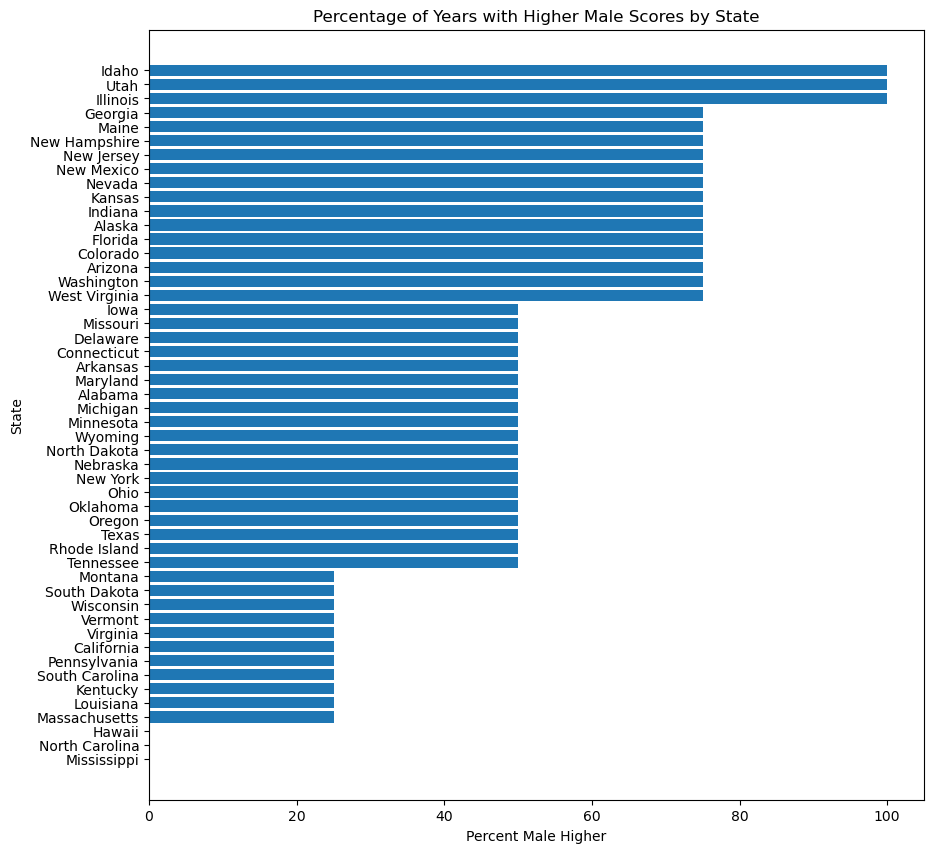

In [9]:
#sort the df
df6_sorted = df6.sort_values(by='percent_higher_male', ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(df6_sorted['state'], df6_sorted['percent_higher_male'])  # Horizontal bar plot
plt.title('Percentage of Years with Higher Male Scores by State')  # Adding a title
plt.xlabel('Percent Male Higher')  # Labeling the x-axis
plt.ylabel('State')  # Labeling the y-axis
plt.show()


## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [10]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]

#A
#using help from stack overflow
#combine state names whilst preserving quotes
combined_list_suffrage = ', '.join(f"'{state}'" for state in list_suffrage)

#create indicator
part7 = f"""
SELECT state, 
       CASE WHEN state IN ({combined_list_suffrage}) 
       THEN 1 
       ELSE 0 
       END AS is_early_voter
FROM math_gencompare
GROUP BY state;
"""

#read as pandas df
df7 = pd.read_sql_query(part7, census)

df7

,state,is_early_voter
0,Alaska,0
1,Alabama,0
2,Arkansas,0
3,Arizona,0
4,California,1
5,Colorado,1
6,Connecticut,0
7,Delaware,0
8,Florida,0
9,Georgia,0


In [14]:
#B
#create indicator
part7b = f"""
SELECT year,is_early_voter,
AVG(CASE WHEN percent_higher_male > 50 
THEN 100 
ELSE 0 
END) AS percent_states_male_higher
FROM (
SELECT year, state, 
AVG(CASE WHEN male > female 
THEN 100 
ELSE 0 
END) AS percent_higher_male,
CASE 
WHEN state IN ({combined_list_suffrage}) 
THEN 1 
ELSE 0 
END AS is_early_voter
FROM math_gencompare
GROUP BY year, state
) AS subquery
GROUP BY year, is_early_voter;
"""

#C 
#read into pandas df
df7b = pd.read_sql_query(part7b, census)

#Print 
df7b


,year,is_early_voter,percent_states_male_higher
0,2013,0,59.0909
1,2013,1,83.3333
2,2015,0,54.5455
3,2015,1,66.6667
4,2017,0,54.5455
5,2017,1,83.3333
6,2019,0,27.2727
7,2019,1,50.0000


## INTERPRET HERE

# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [ ]:
## your code here

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


In [ ]:
## your code here

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [ ]:
# your code here

## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [ ]:
# A. your code here to load data

In [ ]:
# B. your code here to construct binary indicators for male higher

In [ ]:
# C. your code here to melt data

In [ ]:
# D. your code here for train/test split

In [ ]:
# E. your code here to normalize features and fit model

In [ ]:
# F. your code here to interpret feature importances

In [ ]:
# G. your code here to evaluate model